# Predicting Traffic Volume on I-94

This dataset contains 7 years of data of hourly traffic volume for westbound I-94, the years included are 2012, 2013, 2014, 2015, 2016, 2017 and 2018.

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data Introduction
df = pd.read_csv('new_interstate.csv', index_col=0, keep_default_na=False, na_values=['NaN'])

df.head(3)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,is_daytime,time_of_day,day_of_week,month,year
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,Yes,Morning,Tuesday,10,2012
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,Yes,Noon,Tuesday,10,2012
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,Yes,Noon,Tuesday,10,2012


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48204 entries, 0 to 48203
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
 9   is_daytime           48204 non-null  object 
 10  time_of_day          48204 non-null  object 
 11  day_of_week          48204 non-null  object 
 12  month                48204 non-null  int64  
 13  year                 48204 non-null  int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 5.5+ MB


In [4]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,month,year
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355,6.506037,2015.512426
std,13.338232,44.789133,0.008168,39.015750,1986.860670,3.400221,1.893211
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2012.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000,4.000000,2014.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000,7.000000,2016.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000,9.000000,2017.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000,12.000000,2018.000000


The `traffic_volume` column has a minimum entry of 0. From the initial data exploration, we know that this the road was blocked for sometime in 2015 and 2016 due to raod maintenance and construction. 

And during these periods, there were barely any cars on the road.

In [5]:
df[df['traffic_volume'] < 100]['year'].value_counts()

year
2016    57
2015     3
Name: count, dtype: int64

In [6]:
len(df[df['traffic_volume'] < 100])

60

For the predictions, I will be using only data for 2012, 2013, 2014, 2017, 2018, and some parts of 2015 and 2016. This is the records during the road construction are outliers and will not help the model learn the data properly.

So, I'ill proceed by dropping records with extremely low traffic volume (less than 100). There are only 60 entries that mee this condition, and they all fall in 2015 and 2016, which were probably during the road constuction.

In [7]:
# Drop rows where traffic volume is less than 100
df = df.drop(df[df['traffic_volume'] < 100].index)

df.traffic_volume.describe()

count    48144.000000
mean      3263.867751
std       1984.782284
min        100.000000
25%       1200.000000
50%       3385.000000
75%       4934.000000
max       7280.000000
Name: traffic_volume, dtype: float64

### Create new columns

From the data exploration, I discovered that:

Time is the major traffic indicator on the I-94. The data tells us that;
* Traffic is usually heaviest during warm months (March to October) and lowest to cold months (November to February).
* Traffic is usually heavier on weekdays compared to weekends.
* On weekdays, the pick rush hours are around 7AM and 4PM.

From the discoveries above, I'll create 2 new columns;
* `is_weekday`: A column that splits the dataset into weekdays and weekends
* `is_rush`: A column that identifies peak rush hours. 

An optional column is one that identifies each season of the year, since seasons seem to affect traffic volume. This is an optional I might explore later. 
* Spring months: March, April, May
* Summer months: June, July, August
* Fall months: September, October, November
* Winter months: December, January, February

In [8]:
# Convert `date_time` column to datetime
df['date_time'] = pd.to_datetime(df['date_time'])

# Create 'is_weekday' column
df['is_weekday'] = 'Yes'

df.loc[(df['day_of_week'] == 'Saturday') | (df['day_of_week'] == 'Sunday'), 'is_weekday'] = 'No'

df['is_weekday'].value_counts(dropna=False)

is_weekday
Yes    34489
No     13655
Name: count, dtype: int64

In [9]:
# Create a column for rush_hour
df['is_rush_hour'] = 'No'

# Label morning rush hour (between 6am and 9am)
df.loc[(df['is_weekday'] == 'Yes') & (df['date_time'].dt.hour >= 6) & (df['date_time'].dt.hour <= 9), 'is_rush_hour'] = 'Yes'

# Label late afternoon rush hour (between 3pm and 6pm)
df.loc[(df['is_weekday'] == 'Yes') & (df['date_time'].dt.hour >= 15) & (df['date_time'].dt.hour <= 18), 'is_rush_hour'] = 'Yes'

df['is_rush_hour'].value_counts(dropna=False)

is_rush_hour
No     36636
Yes    11508
Name: count, dtype: int64

In [10]:
df[df['is_rush_hour'] == 'Yes']['day_of_week'].value_counts()

day_of_week
Monday       2373
Wednesday    2327
Thursday     2283
Friday       2278
Tuesday      2247
Name: count, dtype: int64

In [13]:
df['season'] = pd.Series()

df.loc[(df['month'] >= 3) & (df['month'] <= 5), 'season'] = 'Spring'
df.loc[(df['month'] >= 6) & (df['month'] <= 8), 'season'] = 'Summer'
df.loc[(df['month'] >= 9) & (df['month'] <= 11), 'season'] = 'Fall'
df.loc[(df['month'] <= 2) | (df['month'] == 12), 'season'] = 'Winter'

df['season'].value_counts(dropna=False)

season
Summer    12893
Spring    12488
Winter    11781
Fall      10982
Name: count, dtype: int64

In [14]:
df.head(3)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,is_daytime,time_of_day,day_of_week,month,year,is_weekday,is_rush_hour,season
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,Yes,Morning,Tuesday,10,2012,Yes,Yes,Fall
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,Yes,Noon,Tuesday,10,2012,Yes,No,Fall
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,Yes,Noon,Tuesday,10,2012,Yes,No,Fall


### Create dummy variables for categorical features

In [15]:
# Remove the holiday and weather_description columns
df = df[['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'date_time', 'traffic_volume', 'is_daytime',
       'time_of_day', 'day_of_week', 'month', 'year', 'is_weekday',
       'is_rush_hour', 'season']]

df.head(3)

,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume,is_daytime,time_of_day,day_of_week,month,year,is_weekday,is_rush_hour,season
0,288.28,0.0,0.0,40,Clouds,2012-10-02 09:00:00,5545,Yes,Morning,Tuesday,10,2012,Yes,Yes,Fall
1,289.36,0.0,0.0,75,Clouds,2012-10-02 10:00:00,4516,Yes,Noon,Tuesday,10,2012,Yes,No,Fall
2,289.58,0.0,0.0,90,Clouds,2012-10-02 11:00:00,4767,Yes,Noon,Tuesday,10,2012,Yes,No,Fall


In [16]:
df.select_dtypes(include='O').describe()

,weather_main,is_daytime,time_of_day,day_of_week,is_weekday,is_rush_hour,season
count,48144,48144,48144,48144,48144,48144,48144
unique,11,2,7,7,2,2,4
top,Clouds,No,Night,Monday,Yes,No,Summer
freq,15150,24293,12138,7072,34489,36636,12893


In [17]:
# Create dummy variables
df = pd.get_dummies(df, drop_first=True, dtype=int)

df.sample(3)

,temp,rain_1h,snow_1h,clouds_all,date_time,traffic_volume,month,year,weather_main_Clouds,weather_main_Drizzle,...,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,is_weekday_Yes,is_rush_hour_Yes,season_Spring,season_Summer,season_Winter
10106,274.66,0.0,0.0,1,2013-11-24 15:00:00,3866,11,2013,0,0,...,0,1,0,0,0,0,0,0,0,0
16767,296.97,0.0,0.0,1,2015-07-22 10:00:00,4503,7,2015,0,0,...,0,0,0,0,1,1,0,0,1,0
38497,275.55,0.0,0.0,90,2017-10-30 15:00:00,5698,10,2017,1,0,...,0,0,0,0,0,1,1,0,0,0


## Feature Selection

### Checking for correlations between variables

<Axes: >

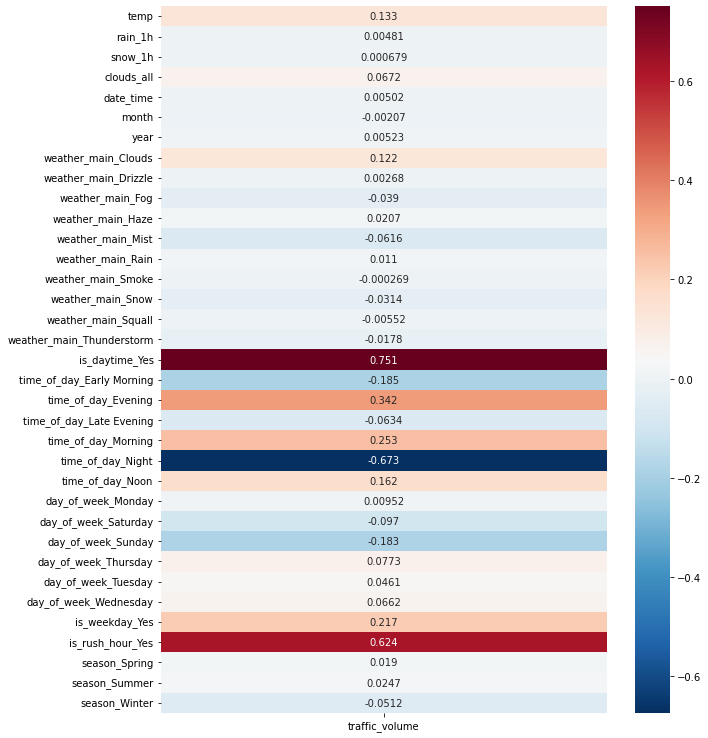

In [18]:
corr_matrix = df.corr()

# Isolate the column corresponding to `exam_score`
corr_target = corr_matrix[['traffic_volume']].drop(labels=['traffic_volume'])

plt.figure(figsize=(10,13))
sns.heatmap(corr_target, annot=True, fmt='.3', cmap='RdBu_r')

From the chart above, the features with the highest correlation with the target variable are `is_daytime_yes`, `is_rush_hour_yes`, and `time_of_day_night` has a negative correlation.

Since most of the features are not correlated with the target variable, a linear regression model is propably not the best model for this data. 

Next, I'll check for multicollinearity amongst the features that most correlates with the target variable.

### Checking for Multicollinearity with VIF

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [20]:
def calculate_vif(df):
    vif = pd.DataFrame()
    vif['features'] = df.columns
    vif['vif_value'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

In [21]:
features = df.drop(['traffic_volume', 'date_time'], axis=1)

calculate_vif(features)

,features,vif_value
0,temp,2.685889
1,rain_1h,1.000621
2,snow_1h,1.007085
3,clouds_all,2.637464
4,month,1.794734
5,year,1.084058
6,weather_main_Clouds,2.899870
7,weather_main_Drizzle,1.506891
8,weather_main_Fog,1.141069
9,weather_main_Haze,1.231341


Some of the features are perfectly correlated with each other (meaning that there's multi-collinearity in the data). This makes sense because I created some of the features from other features, therefore they contain similar information. 

I'll recalculate the VIF using only features that have some correlation with the traget variable `traffic_volume`.

In [22]:
features = df[['is_daytime_Yes', 'time_of_day_Early Morning', 'time_of_day_Evening',
       'time_of_day_Late Evening', 'time_of_day_Morning', 'time_of_day_Night',
       'time_of_day_Noon', 'is_weekday_Yes', 'is_rush_hour_Yes', 'season_Spring', 'season_Summer', 'season_Winter']]

calculate_vif(features)

,features,vif_value
0,is_daytime_Yes,6.073288
1,time_of_day_Early Morning,1.772032
2,time_of_day_Evening,1.958691
3,time_of_day_Late Evening,1.829332
4,time_of_day_Morning,1.989223
5,time_of_day_Night,2.701487
6,time_of_day_Noon,1.424976
7,is_weekday_Yes,1.303450
8,is_rush_hour_Yes,2.410225
9,season_Spring,1.582946


### 

## Model Selection

### Training a Baseline Model with Linear Regression

In [23]:
#from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [24]:
# Defining functions to split data and evaluate model performance

def split_data(df, predictors):
    X_train = df[df['year'] <= 2016][predictors]
    y_train = df[df['year'] <= 2016]['traffic_volume']

    X_test = df[df['year'] > 2016][predictors]
    y_test = df[df['year'] > 2016]['traffic_volume']

    return X_train, y_train, X_test, y_test


def evaluate_model(model, X_test, y_test):
    global predictions
    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse).round(2)
    return rmse

In [25]:
df[df['year'] <= 2016]['traffic_volume'].describe()

count    29590.000000
mean      3237.338966
std       1986.649852
min        100.000000
25%       1177.000000
50%       3323.500000
75%       4923.000000
max       7260.000000
Name: traffic_volume, dtype: float64

In [26]:
df[df['year'] > 2016]['traffic_volume'].describe()

count    18554.000000
mean      3306.175973
std       1981.118811
min        151.000000
25%       1253.250000
50%       3476.000000
75%       4951.750000
max       7280.000000
Name: traffic_volume, dtype: float64

RMSE for the test dataset: 873.97


Text(0.5, 1.0, 'Distribution of Errors')

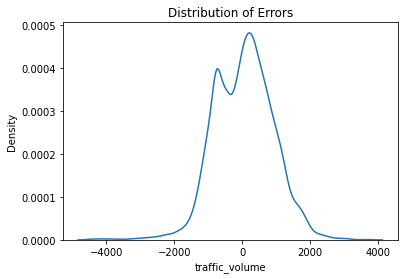

In [27]:
# Select predictors
predictors = ['is_daytime_Yes', 'time_of_day_Early Morning', 'time_of_day_Evening',
       'time_of_day_Late Evening', 'time_of_day_Morning', 'time_of_day_Night',
       'time_of_day_Noon', 'is_weekday_Yes', 'is_rush_hour_Yes', 'season_Spring', 'season_Summer', 'season_Winter']

# Split the data
X_train, y_train, X_test, y_test = split_data(df, predictors)

# Fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Evaluate the model
print(f"RMSE for the test dataset: {evaluate_model(lr, X_test, y_test)}")

# Plot distribution of errors
sns.kdeplot(y_test-predictions)
plt.title('Distribution of Errors')


## Training a Random Forest Regression Model

#### Feature Selection using Extra Trees Regressor

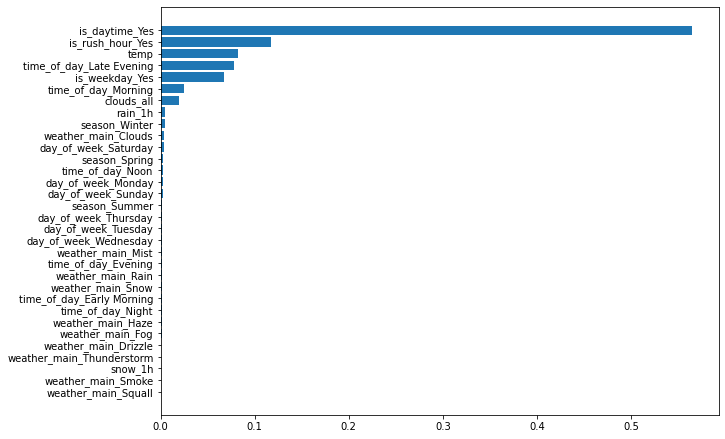

In [29]:
# Feature selection with Embedding method using Extra Trees
from sklearn.ensemble import ExtraTreesRegressor
 
# Load the data
predictors =['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main_Clouds',
       'weather_main_Drizzle', 'weather_main_Fog', 'weather_main_Haze',
       'weather_main_Mist', 'weather_main_Rain', 'weather_main_Smoke',
       'weather_main_Snow', 'weather_main_Squall', 'weather_main_Thunderstorm',
       'is_daytime_Yes', 'time_of_day_Early Morning', 'time_of_day_Evening',
       'time_of_day_Late Evening', 'time_of_day_Morning', 'time_of_day_Night',
       'time_of_day_Noon', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'is_weekday_Yes', 'is_rush_hour_Yes', 'season_Spring', 'season_Summer', 'season_Winter']
       
# Split the data
X_train = df[df['year'] <= 2016][predictors]
y_train = df[df['year'] <= 2016]['traffic_volume']

# Fit the model
selector = ExtraTreesRegressor()
selector.fit(X_train, y_train)

# Check feature importance # the importance of the features is stored inside the feature_importances_
f_i = list(zip(X_train.columns, selector.feature_importances_))
f_i.sort(key = lambda x : x[1])

plt.figure(figsize=(10,7.5))
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

In [205]:
# Build a dictionary with the zipped list: data
data = dict(zip(X_train.columns, selector.feature_importances_))

# Build and inspect a DataFrame from the dictionary: df
df_features = pd.DataFrame().from_dict(data, orient='index', columns=['values'])
df_fearures = df_features.sort_values(by='values', ascending=False)

#plt.figure(figsize=(10,7.5))
#plt.barh(df_features.index, df_features.values)

df_features

,values
temp,0.069997
rain_1h,0.004921
snow_1h,0.000344
clouds_all,0.019318
month,0.012186
weather_main_Clouds,0.004091
weather_main_Drizzle,0.000642
weather_main_Fog,0.000966
weather_main_Haze,0.001149
weather_main_Mist,0.001829


RMSE for the test dataset: 861.07


Text(0.5, 1.0, 'Distribution of Errors')

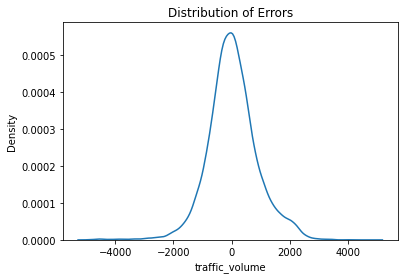

In [31]:
from sklearn.ensemble import RandomForestRegressor

# Load the data
predictors = ['temp', 'is_daytime_Yes', 'rain_1h', 'clouds_all','time_of_day_Late Evening', 
             'time_of_day_Morning', 'is_weekday_Yes', 'is_rush_hour_Yes', 'season_Winter']

# Split the data
X_train, y_train, X_test, y_test = split_data(df, predictors)

# Fit the model
rf = RandomForestRegressor(n_estimators=200, random_state=1, min_samples_leaf=2)
rf.fit(X_train, y_train)

# Evaluate the model
print(f"RMSE for the test dataset: {evaluate_model(rf, X_test, y_test)}")

# Plot distribution of errors
sns.kdeplot(y_test-predictions)
plt.title('Distribution of Errors')


RMSE for the test dataset: 780.04


Text(0.5, 1.0, 'Distribution of Errors')

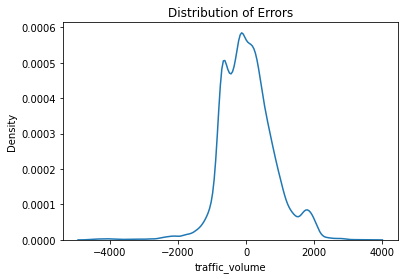

In [32]:
# Load the data
predictors = ['temp', 'is_daytime_Yes', 'rain_1h', 'clouds_all','time_of_day_Late Evening', 
             'time_of_day_Morning', 'is_weekday_Yes', 'is_rush_hour_Yes', 'season_Winter']


# Split the data
X_train, y_train, X_test, y_test = split_data(df, predictors)

# Fit the model
rf2 = RandomForestRegressor(n_estimators=200, random_state=1, max_depth=6, min_samples_leaf=2)
rf2.fit(X_train, y_train)

# Evaluate the model
print(f"RMSE for the test dataset: {evaluate_model(rf2, X_test, y_test)}")

# Plot distribution of errors
sns.kdeplot(y_test-predictions)
plt.title('Distribution of Errors')


RMSE for the test dataset: 777.42


Text(0.5, 1.0, 'Distribution of Errors')

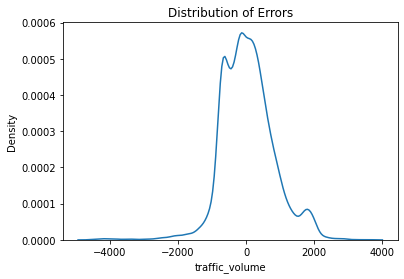

In [36]:
# Load the data
predictors = ['temp', 'is_daytime_Yes', 'clouds_all','time_of_day_Late Evening', 
             'time_of_day_Morning', 'is_weekday_Yes', 'is_rush_hour_Yes', 'season_Winter']


# Split the data
X_train, y_train, X_test, y_test = split_data(df, predictors)

# Fit the model
rf3 = RandomForestRegressor(n_estimators=350, random_state=1, max_depth=8, bootstrap=True, max_samples=1000, min_samples_leaf=2)
rf3.fit(X_train, y_train)

# Evaluate the model
print(f"RMSE for the test dataset: {evaluate_model(rf3, X_test, y_test)}")

# Plot distribution of errors
sns.kdeplot(y_test-predictions)
plt.title('Distribution of Errors')

RMSE for the test dataset: 778.71


Text(0.5, 1.0, 'Distribution of Errors')

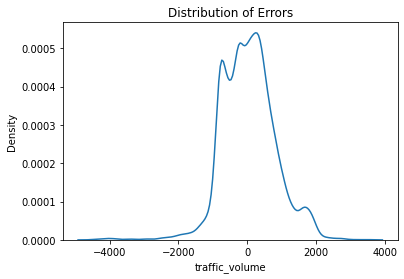

In [67]:
# Load the data
predictors = ['temp', 'is_daytime_Yes', 'clouds_all','time_of_day_Late Evening', 
             'time_of_day_Morning', 'is_weekday_Yes', 'is_rush_hour_Yes', 'season_Winter']


# Split the data
X_train, y_train, X_test, y_test = split_data(df, predictors)

# Fit the model
rf3 = RandomForestRegressor(n_estimators=350, random_state=1, max_depth=6, bootstrap=True, max_samples=1000, max_features=4, min_samples_leaf=2)
rf3.fit(X_train, y_train)

# Evaluate the model
print(f"RMSE for the test dataset: {evaluate_model(rf3, X_test, y_test)}")

# Plot distribution of errors
sns.kdeplot(y_test-predictions)
plt.title('Distribution of Errors')

### Hyperparameter Optimization

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(i) for i in range(100, 510, 50)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(i) for i in range(4, 21, 1)]
# max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

random_grid2 = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

In [ ]:
# Load the data
predictors = ['temp', 'is_daytime_Yes', 'month', 'clouds_all','time_of_day_Late Evening', 
             'time_of_day_Morning', 'is_weekday_Yes', 'is_rush_hour_Yes']


X = df[predictors]
y = df['traffic_volume']

# Split the data
X_train = df[df['year'] <= 2013][predictors]
y_train = df[df['year'] <= 2013]['traffic_volume']

#X_test = df[df['year'] > 2015][predictors]
#y_test = df[df['year'] > 2015]['traffic_volume']

rf = RandomForestRegressor()

# Using randomized search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               scoring='neg_mean_squared_error', cv = 5, verbose=3, random_state=42, n_jobs = 1)

# Fit the data
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_score_

-756589.2865679739

In [ ]:
rf_random.best_params_

{'n_estimators': 450}

## Training an Extra Trees Regression Model

RMSE for the test dataset: 778.68


Text(0.5, 1.0, 'Distribution of Errors')

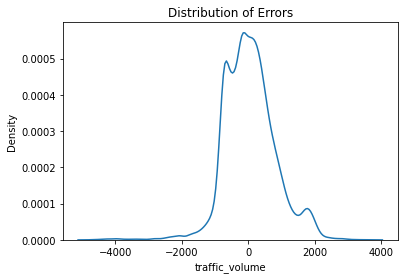

In [77]:
# Load the data
predictors = ['temp', 'is_daytime_Yes', 'clouds_all','time_of_day_Late Evening', 
             'time_of_day_Morning', 'is_weekday_Yes', 'is_rush_hour_Yes', 'season_Winter']


# Split the data
X_train, y_train, X_test, y_test = split_data(df, predictors)

# Fit the model
et = ExtraTreesRegressor(n_estimators=350, max_depth=9, min_samples_leaf=2, bootstrap=True, max_samples=1000)
et.fit(X_train, y_train)

# Evaluate the model
print(f"RMSE for the test dataset: {evaluate_model(et, X_test, y_test)}")

# Plot distribution of errors
sns.kdeplot(y_test-predictions)
plt.title('Distribution of Errors')